<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5Bnew%5D_machine_learning_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM (20개 과거 → 5개 미래)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터 생성
np.random.seed(42)
days = 30
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# 데이터 분할 (정규화 전에!)
split_point = int(len(df) * 0.8)
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

# 정규화 할때 fit은 train에만
scaler = MinMaxScaler()
cpu_train_scaled = scaler.fit_transform(df_train[['cpu']])
cpu_test_scaled = scaler.transform(df_test[['cpu']])

# sequence 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test 시퀀스 생성
X_train, y_train = create_sequences(cpu_train_scaled, past_steps, future_steps)

# test는 train 끝 20개와 test 앞부분을 붙여 sliding (test에 train 안들어가게)
# test_base = np.concatenate([cpu_train_scaled[-past_steps:], cpu_test_scaled])
# X_test, y_test = create_sequences(test_base, past_steps, future_steps)
X_test, y_test = create_sequences(cpu_test_scaled, past_steps, future_steps)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=50, batch_size=16, verbose=1)

pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0291
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0896e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.0459e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.7838e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.6009e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6207e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.2800e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.1667e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.0745e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.1235e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.1265e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.0353e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.0674e-04
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.0455e-04
Epoch 15/50
431/

CNN-LSTM
MAE : 0.5596595155168469
RMSE: 0.702525788722163
R²  : 0.9892436156599104


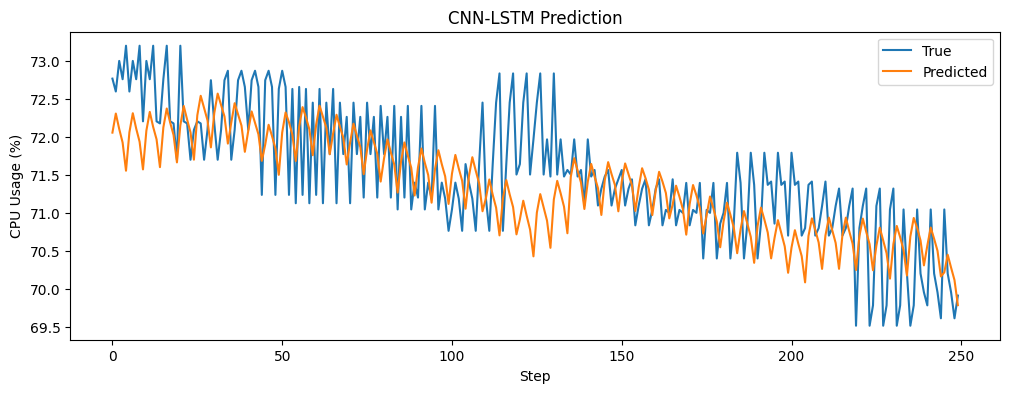

In [7]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

plt.figure(figsize=(12, 4))
plt.plot(true_inv[:50].flatten(), label="True")
plt.plot(pred_inv[:50].flatten(), label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

## 2. 단순 CNN

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

np.random.seed(42)
days = 30
points_per_day = 24 * 12  # 5분 간격
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# 정규화는 train만 fit
split_point = int(len(df) * 0.8)
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

scaler = MinMaxScaler()
cpu_train_scaled = scaler.fit_transform(df_train[['cpu']])
cpu_test_scaled = scaler.transform(df_test[['cpu']])

# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test 시퀀스 구성
X_train, y_train = create_sequences(cpu_train_scaled, past_steps, future_steps)

# test는 train 마지막 20개와 test 앞부분을 이어붙여 구성
# test_base = np.concatenate([cpu_train_scaled[-past_steps:], cpu_test_scaled])
# X_test, y_test = create_sequences(test_base, past_steps, future_steps)
X_test, y_test = create_sequences(cpu_test_scaled, past_steps, future_steps)

# CNN-only 모델
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0211
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1601e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9528e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8386e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7080e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5499e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6082e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2587e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.9312e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9737e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0370e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1569e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8719e-04
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.9605e-04
Epoch 15/50
431/

CNN-only Evaluation
MAE : 0.501817504718301
RMSE: 0.6297739316184423
R²  : 0.9913571862897491


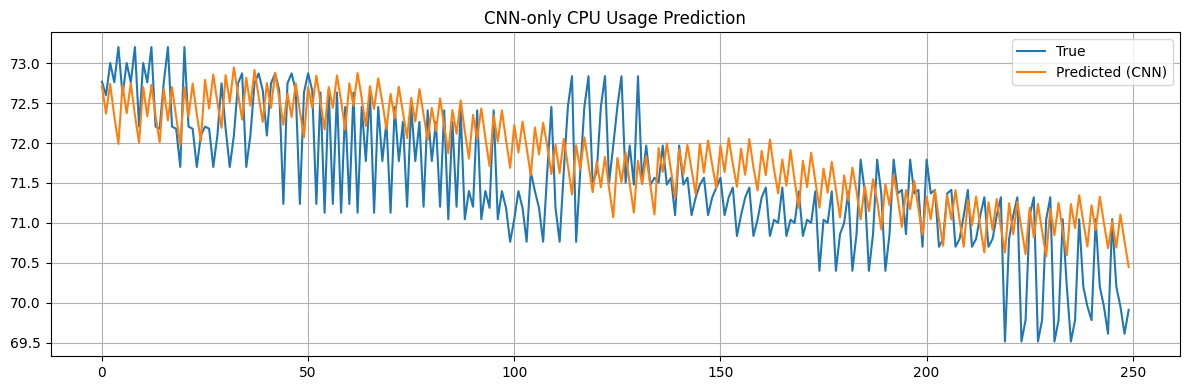

In [9]:
# plot

print("CNN-only Evaluation")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

plt.figure(figsize=(12, 4))
plt.plot(true_inv[:50].flatten(), label="True")
plt.plot(pred_inv[:50].flatten(), label="Predicted (CNN)")
plt.title("CNN-only CPU Usage Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. CNN-LSTM + Autoregressive , (20개 과거 → 1개 미래)를 반복해 하나씩 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense


np.random.seed(42)
days = 30
points_per_day = 24 * 12
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# 미리 나누고 시작
split_point = int(len(df) * 0.8)
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

scaler = MinMaxScaler()
cpu_train_scaled = scaler.fit_transform(df_train[['cpu']])
cpu_test_scaled = scaler.transform(df_test[['cpu']])

def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

X_train, y_train = create_sequences(cpu_train_scaled, past_steps, future_steps)

# CNN-LSTM model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=50, batch_size=16, verbose=1)

# autoregressive 예측
test_base = np.concatenate([cpu_train_scaled[-past_steps:], cpu_test_scaled])
preds, truths = [], []

for i in range(0, len(test_base) - past_steps - future_steps):
    input_seq = test_base[i:i+past_steps].reshape(1, past_steps, 1)
    pred_seq = []
    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        pred_seq.append(pred[0][0])
        input_seq = np.append(input_seq[:, 1:, :], [[[pred[0][0]]]], axis=1)
    preds.append(pred_seq)
    truths.append(test_base[i+past_steps:i+past_steps+future_steps].flatten())

preds_inv = scaler.inverse_transform(np.array(preds))
truths_inv = scaler.inverse_transform(np.array(truths))

mae = mean_absolute_error(truths_inv, preds_inv)
rmse = np.sqrt(mean_squared_error(truths_inv, preds_inv))
r2 = r2_score(truths_inv, preds_inv)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0533
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.0756e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.8579e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8501e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.5606e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.4095e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.2102e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.2684e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.3039e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.1795e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.0216e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.0375e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.9169e-04
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.9361e-04
Epoch

In [ ]:
# plot

print("Result for Autoregressive CNN-LSTM")
print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)

plt.figure(figsize=(12, 5))
plt.plot(truths_inv.flatten()[:200], label='True')
plt.plot(preds_inv.flatten()[:200], label='Predicted', alpha=0.7)
plt.title('Autoregressive CNN-LSTM Prediction (Multiple Windows)')
plt.xlabel('Step')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. FLNN + GA-PSO

In [10]:
!pip install deap pyswarms

import numpy as np
import pandas as pd
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from deap import base, creator, tools, algorithms
import pyswarms as ps
import matplotlib.pyplot as plt

np.random.seed(42)
days = 90
points_per_day = 24 * 12
total_points = days * points_per_day
theta = np.linspace(0, 20*np.pi, total_points)
base_wave = 0.6*np.sin(theta) + 0.3*sawtooth(theta*0.2) + np.random.normal(0, 0.02, total_points)
long_wave = 0.2 * np.sin(theta * 0.05)
spikes = np.zeros_like(theta)
spikes[np.random.choice(len(theta), 30, replace=False)] = np.random.uniform(-1.5, 1.5, size=30)
cpu = np.where(base_wave + long_wave + spikes < 0, (base_wave + long_wave + spikes) * 1.4, (base_wave + long_wave + spikes) * 0.9)
df = pd.DataFrame({'cpu': cpu})

def make_sliding(series, steps=5):
    X, y = [], []
    for i in range(len(series) - steps - 1):
        X.append(series[i:i+steps])
        y.append(series[i+steps])
    return np.array(X), np.array(y)

# train/test 분할
split_point = int(len(df) * 0.8)
series_train = df[:split_point]['cpu'].values
series_test = df[split_point:]['cpu'].values
past_steps = 5

# 슬라이딩 구성
X_train_raw, y_train_raw = make_sliding(series_train, steps=past_steps)

# test는 train 마지막 N개 + test 앞부분으로 연결
# window_base = np.concatenate([series_train[-past_steps:], series_test])
# X_test_raw, y_test_raw = make_sliding(window_base, steps=past_steps)
X_test_raw, y_test_raw = make_sliding(series_test, steps=past_steps)

# 정규화 (입력/출력 분리)
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train_raw)
X_test = x_scaler.transform(X_test_raw)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test_raw.reshape(-1, 1)).flatten()

# FLNN
def flnn_predict(w, X):
    return np.dot(X, w[:-1]) + w[-1]

# GA
def eval(ind):
    return (np.abs(flnn_predict(np.array(ind), X_train) - y_train).mean(),)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=past_steps+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval)

pop = toolbox.population(n=30)
pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=15, verbose=False)
best_ga = tools.selBest(pop, 1)[0]

# PSO
def pso_obj(w):
    return np.array([np.abs(flnn_predict(p, X_train) - y_train).mean() for p in w])

optimizer = ps.single.GlobalBestPSO(
    n_particles=20,
    dimensions=past_steps+1,
    options={'c1':1.5, 'c2':1.5, 'w':0.7},
    init_pos=np.tile(best_ga, (20, 1)) + np.random.normal(0, 0.1, (20, past_steps+1))
)
_, best_pso = optimizer.optimize(pso_obj, iters=100)

y_pred = flnn_predict(best_pso, X_test)
y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()



/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
2025-07-30 14:30:40,342 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0094
2025-07-30 14:30:40,871 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.009402905541807482, best pos: [-0.14528977 -0.49044254  1.06627475 -0.39027593  0.95381141  0.0039506 ]


FLNN (GA+PSO)
MAE : 0.03300558801658758
RMSE: 0.049353628534057434
R2  : 0.986479801940371


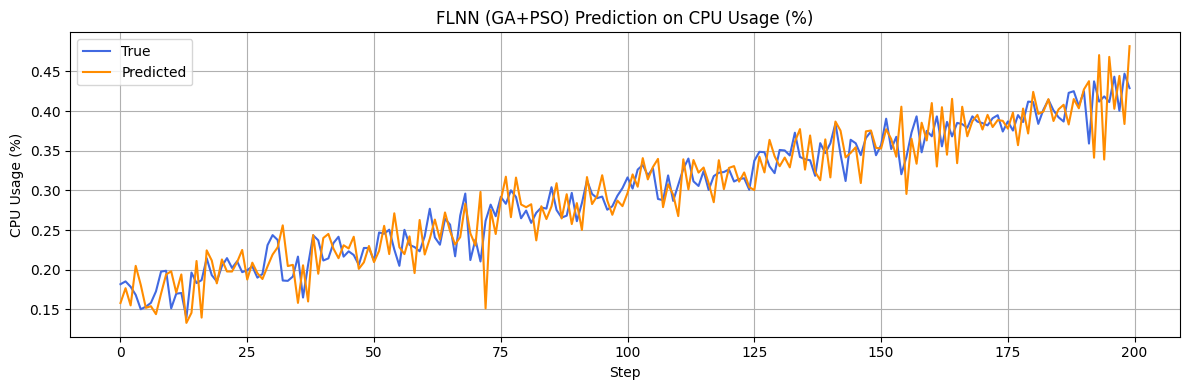

In [12]:
# plot

print("FLNN (GA+PSO)")
print("MAE :", mean_absolute_error(y_test_inv, y_pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print("R2  :", r2_score(y_test_inv, y_pred_inv))

plt.figure(figsize=(12, 4))
plt.plot(y_test_inv[:200], label='True', color='royalblue')
plt.plot(y_pred_inv[:200], label='Predicted', color='darkorange')
plt.title("FLNN (GA+PSO) Prediction on CPU Usage (%)")
plt.xlabel("Step")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기